In [1]:
using DifferentialEquations
using ModelingToolkit
using LinearAlgebra
using Plots
using Colors
using Images
using Statistics
using Sundials
using Random
using JLD2

Using 3 species instead of an explicit time delay allows for using faster solver and does not require nearly as much memory to run.

Added diffusion for pak that is a little faster than rhoT to prevent chasing, where rhoT creates waves, and because makes sense for peripheral protein.

Oscillation and equalization observed.

With same concentration of total Rho as simpilist with scaling model, this produces more polarity patches (as parameterized).
Reducing concentration reduces patch number.
In cells we see same or maybe fewer buds for a cell of a given size when neg FB is still intact. 

Increasing negative feedback strength by doubling its effect on RhoT (param "e") increaced patch number from 14 to 16. (no negFB -> 4)
Reducing negative feedback strength (halving e) decreased patch number to 11.

In [2]:
function setup(r)
    # Generate constants
    N = 100
    SA = 4*pi*r^2
    V = (4/3)*pi*r^3
    mem_thickness = 0.01
    n = (mem_thickness * SA) / V

    Ax = Array(Tridiagonal([1.0 for i in 1:N-1],[-2.0 for i in 1:N],[1.0 for i in 1:N-1]))
    Ax[1,end] = 1.0
    Ax[end,1] = 1.0
    dx = (r*sqrt(pi))/N
    Ax = Ax/(dx^2) # adjust for 1/microns
    Ay = copy(Ax)

    r0 = zeros(100,100,3)
    Random.seed!(1)
    r0[:,:,1] .= 10 .*(rand.())   # Cdc42-GTPm
    r0[:,:,2] .= .2 - mean(r0[:,:,1])*n   # Cdc42-GDPm
    r0[:,:,3] .= 0
    
    # Dummy parameters used only locally in fxn but passed to specify scope, or something..
    Ayt = zeros(N,N)
    tAx = zeros(N,N)
    D42t = zeros(N,N)
    D42d = zeros(N,N)
    Dpak = zeros(N,N)
    R = zeros(N,N)
    dummy = (Ayt, tAx, D42t, D42d, Dpak, R)
    # Actual parameters
    a = 1
    b = 0.25
    c = .5
    d = 0.001
    e = 0.1
    Dm = 0.01
    Dc = 10
    Dm2 = 0.02
    n = n

    p = (a, b, c, d, e, Dm, Dc, Dm2, n, Ax, Ay, dummy)
    return p, r0
end

setup (generic function with 1 method)

In [6]:
function simple!(dr,r,p,t)
    a, b, c, d, e, Dm, Dc, Dm2, n, Ax, Ay, dummy = p
    Ayt, tAx, D42t, D42d, Dpak, R = dummy
    # Window variables
    rhoT = @view r[:,:,1]
    rhoD = @view r[:,:,2]
    pak = @view r[:,:,3]
    # Calculate diffusion
    mul!(Ayt,Ay,rhoT)
    mul!(tAx,rhoT,Ax)
    @. D42t = Dm*(Ayt + tAx)
    mul!(Ayt,Ay,rhoD)
    mul!(tAx,rhoD,Ax)
    @. D42d = Dc*(Ayt + tAx)
    mul!(Ayt,Ay,pak)
    mul!(tAx,pak,Ax)
    @. Dpak = Dm2*(Ayt + tAx)
    # Calculate reactions, add diffusion
    @. R = (a*rhoT^2*rhoD) - b*rhoT - c*rhoT*pak^2
    @. dr[:,:,1] = R + D42t
    @. dr[:,:,2] = -R*n + D42d
    @. dr[:,:,3] = d*rhoT - e*pak + Dpak
end


simple! (generic function with 1 method)

In [29]:
function run(radius)
    p, r0 = setup(radius)
    min_prob = ODEProblem(simple!,r0,(0.0,1800),p)
    sol_simp = solve(min_prob,CVODE_BDF(linear_solver = :GMRES),saveat=1)
    return sol_simp
end

run (generic function with 1 method)

In [32]:
sol = run(2.9)

retcode: Success
Interpolation: 1st order linear
t: 1801-element Vector{Float64}:
    0.0
    1.0
    2.0
    3.0
    4.0
    5.0
    6.0
    7.0
    8.0
    9.0
    ⋮
 1792.0
 1793.0
 1794.0
 1795.0
 1796.0
 1797.0
 1798.0
 1799.0
 1800.0
u: 1801-element Vector{Array{Float64, 3}}:
 [0.7336635446929285 1.670529092877866 … 4.498294423109524 4.346647867723758; 3.4924148955718612 7.197206925405183 … 8.084217249744095 9.244406861511123; … ; 8.338534481533054 3.6131523841038513 … 3.295155127929638 5.904229678435289; 9.817043479487307 3.618757071379193 … 3.1065190965909384 2.26016435978588;;; 0.1482211242873429 0.1482211242873429 … 0.1482211242873429 0.1482211242873429; 0.1482211242873429 0.1482211242873429 … 0.1482211242873429 0.1482211242873429; … ; 0.1482211242873429 0.1482211242873429 … 0.1482211242873429 0.1482211242873429; 0.1482211242873429 0.1482211242873429 … 0.1482211242873429 0.1482211242873429;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [9.

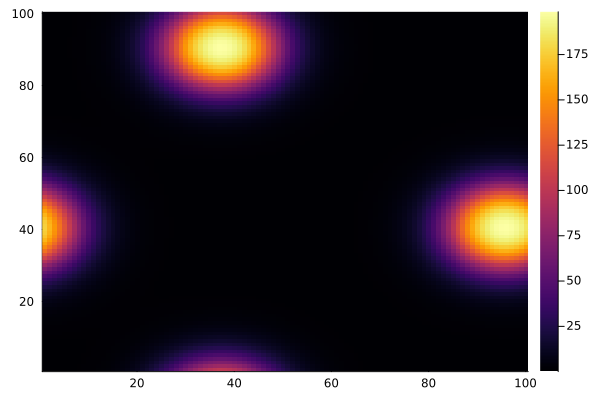

In [34]:
heatmap(sol[:,:,1,end])

┌ Info: Saved animation to /tmp/jl_OBUfMzCLKj.gif
└ @ Plots /home/dinosaur/.julia/packages/Plots/HyyIK/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_OBUfMzCLKj.gif")
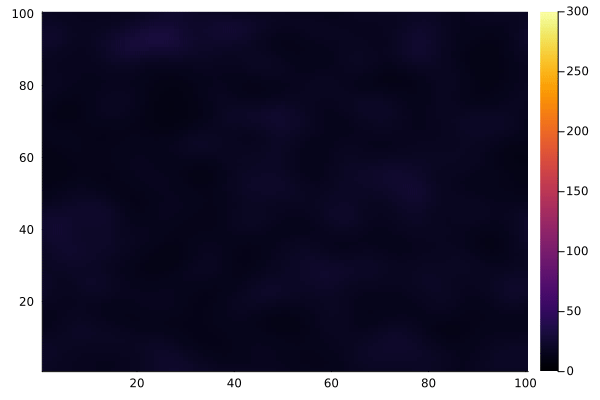

In [36]:
anim = @animate for i in 1:600
    Plots.heatmap(sol[:,:,1,i*3],clim=(0,200))
end
gif(anim, fps=60)
#gif(anim, "tmp_negFB_r3.gif", fps=60)